In [1]:
import time
import json
import torch.nn.functional as F
import math
from pathlib import Path
import torch

In [2]:
# from skimage import io
from torchvision.datasets import LFWPairs
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                
    transforms.Normalize(
                    mean=[0.4332, 0.3757, 0.3340], std=[0.2711, 0.2446, 0.2346]
    )
])

lfw_train_dataset = LFWPairs(
    root='/scratch/sj4020/lfw/',
    transform=transform,
    target_transform=None,
    download=True,
    split='train'
)


Files already downloaded and verified


In [3]:
lfw_test_dataset = LFWPairs(
    root='/scratch/sj4020/lfw/',
    transform=transform,
    target_transform=None,
    download=True,
    split='test'
)


Files already downloaded and verified


In [4]:
print(f"Number of images: {len(lfw_train_dataset)}")

Number of images: 2200


In [5]:
print(f"Number of images: {len(lfw_test_dataset)}")

Number of images: 1000


In [6]:
import argparse
from pathlib import Path
class Args:
    def __init__(self):
        self.arch = 'resnet50'
        self.mlp = '8192-8192-8192'
        self.sim_coeff=25
        self.std_coeff=25
        self.cov_coeff=1
        self.batch_size = 256
        self.log_freq_time=60
        self.base_lr=0.2
        self.exp_dir=Path("./exp")
        self.epochs=50
        self.wd=1e-6

args = Args()
# namespace = argparse.Namespace(**vars(args))

In [7]:
def exclude_bias_and_norm(p):
    return p.ndim == 1

In [8]:
import resnet
from torch import nn
class VICReg(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.num_features = int(args.mlp.split("-")[-1])
        self.backbone, self.embedding = resnet.__dict__[args.arch](zero_init_residual=True)
        self.projector = Projector(args, self.embedding)

    def forward(self, x, y):
        x = self.projector(self.backbone(x))
        y = self.projector(self.backbone(y))

        repr_loss = F.mse_loss(x, y)

        # x = torch.cat(x, dim=0)
        # y = torch.cat(y, dim=0)
        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        std_x = torch.sqrt(x.var(dim=0) + 0.0001)
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        cov_x = (x.T @ x) / (self.args.batch_size - 1)
        cov_y = (y.T @ y) / (self.args.batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
            self.num_features
        ) + off_diagonal(cov_y).pow_(2).sum().div(self.num_features)

        loss = (
            self.args.sim_coeff * repr_loss
            + self.args.std_coeff * std_loss
            + self.args.cov_coeff * cov_loss
        )
        return loss



def Projector(args, embedding):
    mlp_spec = f"{embedding}-{args.mlp}"
    layers = []
    f = list(map(int, mlp_spec.split("-")))
    for i in range(len(f) - 2):
        layers.append(nn.Linear(f[i], f[i + 1]))
        layers.append(nn.BatchNorm1d(f[i + 1]))
        layers.append(nn.ReLU(True))
    layers.append(nn.Linear(f[-2], f[-1], bias=False))
    return nn.Sequential(*layers)


In [9]:
model = VICReg(args).cuda()

In [68]:
ckpt=torch.load("exp/model_lfw_itr1.pth")

In [69]:
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [50]:
import augmentations as aug
transform_aug = aug.TrainTransform()

In [51]:
import numpy as np

# Linear Evaluation

In [70]:
X_train = []
model.eval()
# Define batch size
batch_size = 128
y_train=[]
# Create DataLoader object
lfw_train_loader = torch.utils.data.DataLoader(lfw_train_dataset, batch_size=batch_size, shuffle=True)

# Process the batches
for batch in lfw_train_loader:
    x, y, target = batch
    x = x.cuda()
    y = y.cuda()
    with torch.no_grad():
        embed_x = model.projector(model.backbone(x))
        embed_y = model.projector(model.backbone(y))
        loss=F.mse_loss(embed_x, embed_y, reduction='none')
        mean_mse_loss = torch.mean(loss, dim=1).cpu().numpy().tolist()
        X_train.extend(mean_mse_loss)
    y_train.extend(target)
X_train = torch.tensor(X_train)

In [71]:
X_test = []
model.eval()
y_test=[]
# Define batch size
batch_size = 128

# Create DataLoader object
lfw_test_loader = torch.utils.data.DataLoader(lfw_test_dataset, batch_size=batch_size, shuffle=False)

for batch in lfw_test_loader:
    x, y, target = batch
    x = x.cuda()
    y = y.cuda()
    with torch.no_grad():
        embed_x = model.projector(model.backbone(x))
        embed_y = model.projector(model.backbone(y))
        loss=F.mse_loss(embed_x, embed_y, reduction='none')
        mean_mse_loss = torch.mean(loss, dim=1).cpu().numpy().tolist()
        X_test.extend(mean_mse_loss)
    y_test.extend(target)
X_test = torch.tensor(X_test)

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
# Instantiate and train the logistic regression model
clf = LogisticRegression(solver='liblinear')
clf.fit(X_train.unsqueeze(1), y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test.unsqueeze(1))

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.87


In [73]:
print(clf.intercept_)
print(clf.coef_)

[2.04333787]
[[-8.91177617]]


# ANNs

In [58]:
import os
from PIL import Image
from torch.utils.data import Dataset

class ImageFolderDataset(Dataset):
    """Dataset class that loads all images in a folder recursively"""

    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.filenames = []
        self.images = []
        self._load_images()

    def _load_images(self):
        for dirpath, _, filenames in os.walk(self.root):
            for filename in filenames:
                if self._is_image_file(filename):
                    filepath = os.path.join(dirpath, filename)
                    image = Image.open(filepath).convert('RGB')
                    self.images.append(image)
                    self.filenames.append(filepath)

    def _is_image_file(self, filename):
        return filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))

    def __getitem__(self, index):
        image = self.images[index]
        if self.transform is not None:
            image = self.transform(image)
        filename = self.filenames[index]
        return image, filename

    def __len__(self):
        return len(self.images)



In [59]:
dataset = ImageFolderDataset('/scratch/sj4020/lfw', transform=transform_aug.simple_transform)
print(len(dataset)) # print the number of images in the dataset
image, filename = dataset[0] # load the first image and filename
print(filename) # print the filename of the first image


13233
/scratch/sj4020/lfw/lfw-py/lfw_funneled/Julianne_Moore/Julianne_Moore_0019.jpg


In [60]:
def compute_embedding(image):
    model.eval()
    with torch.no_grad():
        x = image.cuda()
        embed_x = model.projector(model.backbone(x.unsqueeze(0))).squeeze(0)
    return embed_x.cpu().numpy()

In [61]:
from tqdm import tqdm
from annoy import AnnoyIndex

In [62]:
# Compute embeddings for all images and index them in an Annoy tree
embedding_size = 8192
annoy_tree = AnnoyIndex(embedding_size, 'euclidean')
filenames_to_index = {}
for i, (image, target) in enumerate(tqdm(dataset)):
    embedding = compute_embedding(image)
    filenames_to_index[dataset.filenames[i]] = i
    annoy_tree.add_item(i, embedding)
annoy_tree.build(100)



100%|██████████| 13233/13233 [02:35<00:00, 85.18it/s]


True

In [75]:
# Query the top 5 similar images for a given image
query_filename = '/scratch/sj4020/lfw/lfw-py/lfw_funneled/George_W_Bush/George_W_Bush_0001.jpg'
query_index = filenames_to_index[query_filename]
query_embedding = compute_embedding(dataset[query_index][0])
similar_indices, similarity_scores = annoy_tree.get_nns_by_vector(query_embedding, 4, include_distances=True)
similar_filenames = [dataset.filenames[i] for i in similar_indices]
print(similar_filenames)

['/scratch/sj4020/lfw/lfw-py/lfw_funneled/George_W_Bush/George_W_Bush_0001.jpg', '/scratch/sj4020/lfw/lfw-py/lfw_funneled/George_W_Bush/George_W_Bush_0374.jpg', '/scratch/sj4020/lfw/lfw-py/lfw_funneled/George_W_Bush/George_W_Bush_0024.jpg', '/scratch/sj4020/lfw/lfw-py/lfw_funneled/George_W_Bush/George_W_Bush_0209.jpg']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


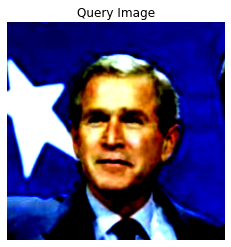

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


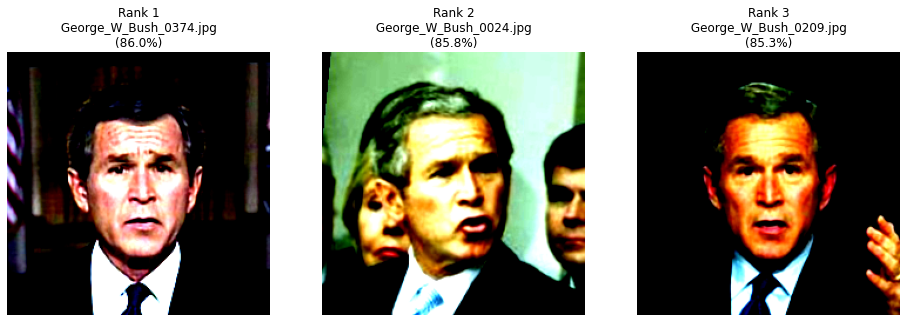

In [76]:
import matplotlib.pyplot as plt

# Display the query image
query_image, _ = dataset[query_index]
plt.imshow(query_image.permute(1, 2, 0).numpy())
plt.title('Query Image')
plt.axis('off')
plt.show()


# Display the similar images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i, filename in enumerate(similar_filenames[1:]):
    image, _ = dataset[filenames_to_index[filename]]
    axes[i].imshow(image.permute(1, 2, 0).numpy())
#     axes[i].set_title(f'Similar Image {i+1}')
    axes[i].set_title(f'Rank '+str(i+1)+f'\n {filename.split("/")[-1]} \n({100-similarity_scores[i+1]:.1f}%)')
    axes[i].axis('off')
plt.show()

In [77]:
# Query the top 5 similar images for a given random image

random_query_index = 35
query_embedding = compute_embedding(dataset[random_query_index][0])
similar_indices, similarity_scores = annoy_tree.get_nns_by_vector(query_embedding, 4,include_distances=True)
similar_filenames = [dataset.filenames[i] for i in similar_indices]
print(similar_filenames)

['/scratch/sj4020/lfw/lfw-py/lfw_funneled/Rudolph_Giuliani/Rudolph_Giuliani_0004.jpg', '/scratch/sj4020/lfw/lfw-py/lfw_funneled/Rudolph_Giuliani/Rudolph_Giuliani_0002.jpg', '/scratch/sj4020/lfw/lfw-py/lfw_funneled/Rudolph_Giuliani/Rudolph_Giuliani_0017.jpg', '/scratch/sj4020/lfw/lfw-py/lfw_funneled/Jay_Rasulo/Jay_Rasulo_0002.jpg']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


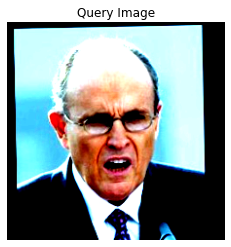

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


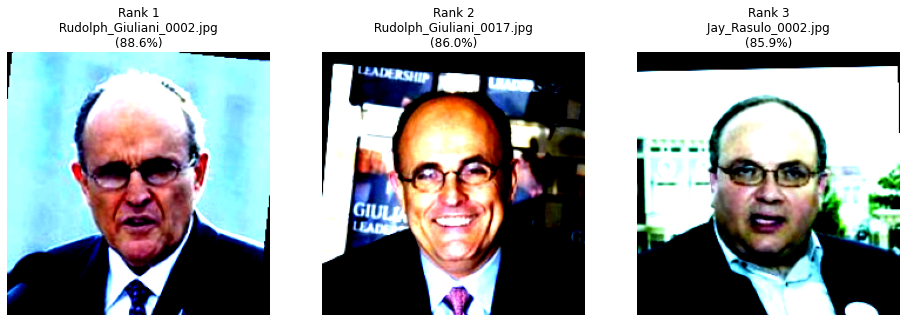

In [78]:
# Display the query image
query_image, _ = dataset[random_query_index]
plt.imshow(query_image.permute(1, 2, 0).numpy())
plt.title('Query Image')
plt.axis('off')
plt.show()


# Display the similar images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
for i, filename in enumerate(similar_filenames[1:]):
    image, _ = dataset[filenames_to_index[filename]]
    axes[i].imshow(image.permute(1, 2, 0).numpy())
    axes[i].set_title(f'Similar Image {i+1}')
    axes[i].set_title(f'Rank '+str(i+1)+f'\n {filename.split("/")[-1]} \n({100-similarity_scores[i+1]:.1f}%)')
    axes[i].axis('off')
plt.show()

In [79]:
##writes

import pickle

# Save the dictionary to disk
with open('exp/filenames_to_index_itr2.pkl', 'wb') as f:
    pickle.dump(filenames_to_index, f)
    
annoy_tree.save('exp/lfw_index_itr2.ann')

In [74]:
##reads

import pickle

# Load the dictionary from disk
with open('exp/filenames_to_index_itr1.pkl', 'rb') as f:
    filenames_to_index = pickle.load(f)
    
annoy_tree= AnnoyIndex(8192, metric='euclidean')
annoy_tree.load('exp/lfw_index_itr1.ann')

True